## `TimeSeries Forecasting Model`
* <b>File Name</b> : Reference_implementation
* <b>Date of creation(dd-mm-yyyy)</b> : 08-05-2023
* <b>Author Name/Dept</b> : AIShield
* <b>Organization</b> : BGSW
* <b>Description</b> : Source Code of reference implementation
* <b>Copyright</b> : Copyright 2022 Bosch Global Software Technologies Private Limited. All Rights Reserved.

### Metadata
* <b>Dataset</b> : hourly energy consumption
* <b>Size of training set</b>: 113927
* <b>Size of testing set</b> : 31439
* <b>Original Model</b>: XGBoost

### Outcomes
* <b>RMSE Score of model</b>: 0.013

<a target="_blank" href="https://colab.research.google.com/github/bosch-aisecurity-aishield/Reference-Implementations/blob/main/Product_Taskpair_wise/TimeSeries_Forecasting/Extraction/PyPi_Extraction_Reference_Implementation_TSF_ML.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [33]:
# # Install AIShield SDK.
# # If not already installed, install by uncommenting the code below

# !pip install aishield

In [1]:
"""
Description: commands to install all the packages, remove comments to install all the libraries
"""
# ! pip install xgboost==1.6.2
# ! pip install pandas==1.5.1
# ! pip install scikit-learn==1.1.3
# ! pip install numpy==1.23.4
# ! pip install pyminizip
# !pip install requests==2.28.0
# !pip install humanfriendly==9.2

'\nDescription: commands to install all the packages, remove comments to install all the libraries\n'

## `1.0 Import Libraries`

In [35]:
"""
Description: Import libraries
"""
import cv2
import os
import json
import time
import shutil
import random
import pickle
import zipfile 
import requests
import warnings
import pyminizip
import py_compile
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf

warnings.filterwarnings('ignore')


#importing AIShield Library
import aishield as ais

## `2.0 Data Loading and Pre-processing`

#### Download dataset from the link https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost/input?select=PJME_hourly.csv

1. then download the PJME_hourly.csv file

In [4]:
'''
Description : Loading hourlyenergy consumption dataset
'''

data =  pd.read_csv("PJME_hourly/PJME_hourly.csv", index_col=[0], parse_dates=[0])

In [5]:
data.shape

(145366, 1)

In [6]:
'''
convert series to supervised learning
''' 
def series_to_supervised(data, n_vars_out, n_in, n_out=1, fillnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i).iloc[:,n_vars_out])
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in (n_vars_out)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in (n_vars_out)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Replace nan values with 0
    if fillnan:
        agg = agg.fillna(0)
    return agg

In [7]:
def data_prep(df, input_dims, pred_out):    
    # convert input dims to number of timesteps and number of features
    num_timesteps, num_features = 100,1#input_dims
    
    # generate data samples by window sliding through time series data
    reframed = series_to_supervised(df, pred_out, num_timesteps)
    data = reframed.values
    
    # split into input and outputs
    n_obs = num_timesteps*num_features  # no. of timesteps * features 
    data_x, data_y = data[:, :n_obs], data[:, n_obs:]
    
    # reshape input to be 3D [samples, timesteps, features]
    data_x = data_x.reshape((data_x.shape[0], num_timesteps, num_features))
    
    return data_x, data_y

In [8]:
values = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [9]:
'''
Description : convert normalized dataset to a dataframe 
'''

df_scaled = pd.DataFrame(scaled,columns = data.columns )

In [10]:
'''
Description : choosing train and testing dataset
'''

df_train = df_scaled.iloc[0:113927].copy()
df_test = df_scaled.iloc[113927:145366].copy()

In [11]:
'''
Description : Splitting data for training and testing 
'''

input_shape = (100,1)
pred_col_index = [len(df_train.columns) - 1]
x_train, y_train = data_prep(df_train, input_shape, pred_col_index)
x_test, y_test = data_prep(df_test, input_shape, pred_col_index)

In [12]:
'''
Description : Check size of dataset
'''
print("x_train Shape :",x_train.shape)
print("y_train Shape:",y_train.shape)
print("x_test Shape:",x_test.shape)
print("y_test Shape:",y_test.shape)

x_train Shape : (113927, 100, 1)
y_train Shape: (113927, 1)
x_test Shape: (31439, 100, 1)
y_test Shape: (31439, 1)


array([<AxesSubplot:>], dtype=object)

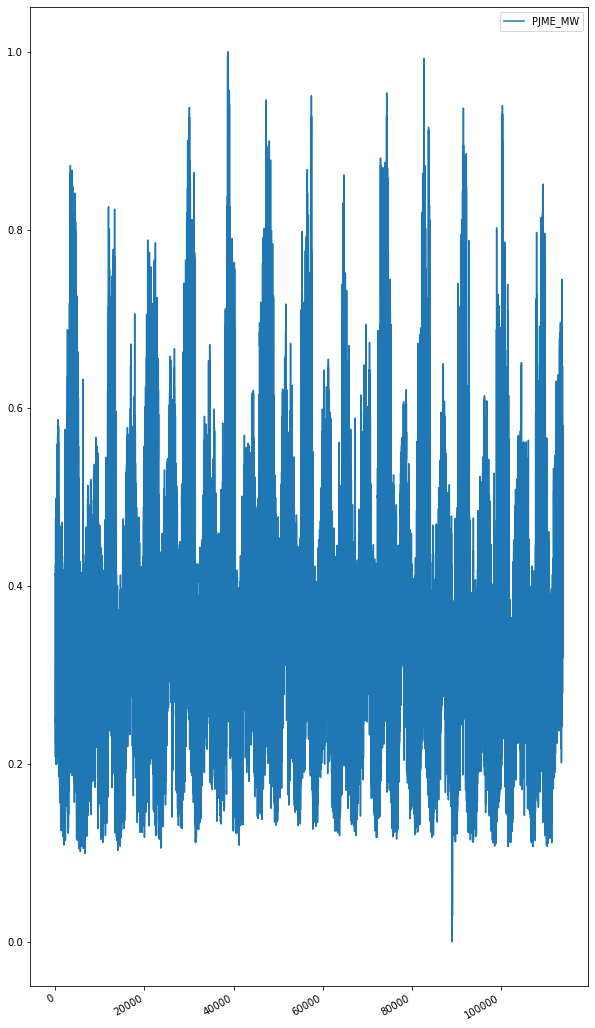

In [13]:
'''
Description : Plotting the graphs
'''

df_train.plot(subplots =True, sharex = True, figsize = (10,20))

In [14]:
def make_directory(directory):
    """
    create directory

    Parameters
    ----------
    directorys : list containing the directorys path to create 
    Returns
    -------q
    None.

    """
    for d in directory:
        if os.path.isdir(d):
            print("directory {} already exist".format(d))
        if os.path.isdir(d)==False:
            os.mkdir(path=d)
            print("directory {} created successfully".format(d))

In [15]:
def delete_directory(directorys):
    """
    delete directory 

    Parameters
    ----------
    directorys : list containing the directorys to deleate along with all the files

    Returns
    -------
    None.

    """
    if len(directorys)>=1:
        for d in directorys:
            if os.path.isdir(d):
                try:
                    if os.path.isfile(d):
                        os.remove(path=d)
                    else:
                        shutil.rmtree(path=d)
                        print("Removed: {}".format(d))
                except:
                    print("Failed to removed: {}".format(d))
            else:
                print("Failed to removed: {}".format(d))
                

In [16]:
def make_archive(base_name,root_dir,zip_format='zip'):
    """
    created zip for given folder

    Parameters
    ----------
    base_name : name of zip file
    root_dir : directory to archive/zip
    zip_format : zip or tar 
        DESCRIPTION. The default is 'zip'.

    Returns
    -------
    None.

    """
    shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir)
    

In [93]:
"Description : Create data, model and label folder"
data_path=os.path.join(os.getcwd(),"data")
model_path=os.path.join(os.getcwd(),"model")
minmax_path=os.path.join(os.getcwd(),"minmax")
zip_path=os.path.join(os.getcwd(),"zip")
pyc_model_path=os.path.join(os.getcwd(),"pycmodel")
report_path = os.path.join(os.getcwd(),"reports")
#deleting folder
delete_directory(directorys=[data_path,model_path,minmax_path,zip_path,pyc_model_path,report_path])

#creating folder
make_directory([data_path,model_path,minmax_path,zip_path,pyc_model_path,report_path])


'Description : Create data, model and label folder'

## `3.0 Model Development and Training`


In [18]:
"""
Description: Create model architecture
"""

def getmodel():
    model = xgb.XGBRegressor(n_estimators=1000)
    
    return model

In [19]:
"""
Description: to get root mean squared error of the model 
"""
def RMSE_score(model, test_x, test_y):
    pred_y = model.predict(test_x)
    return np.sqrt(mean_squared_error(pred_y, test_y))


In [20]:
"""
Description: Model summary
"""
model= getmodel()
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)

In [21]:
"""
Description: Training model
"""

x_train = x_train[:,:,0]
x_test = x_test[:,:,0]

history = model.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=5,
       verbose=True)

[0]	validation_0-rmse:0.13103	validation_1-rmse:0.14142
[1]	validation_0-rmse:0.09309	validation_1-rmse:0.10079
[2]	validation_0-rmse:0.06670	validation_1-rmse:0.07240
[3]	validation_0-rmse:0.04852	validation_1-rmse:0.05286
[4]	validation_0-rmse:0.03615	validation_1-rmse:0.03957
[5]	validation_0-rmse:0.02790	validation_1-rmse:0.03074
[6]	validation_0-rmse:0.02260	validation_1-rmse:0.02509
[7]	validation_0-rmse:0.01926	validation_1-rmse:0.02151
[8]	validation_0-rmse:0.01724	validation_1-rmse:0.01940
[9]	validation_0-rmse:0.01600	validation_1-rmse:0.01807
[10]	validation_0-rmse:0.01526	validation_1-rmse:0.01731
[11]	validation_0-rmse:0.01476	validation_1-rmse:0.01680
[12]	validation_0-rmse:0.01438	validation_1-rmse:0.01643
[13]	validation_0-rmse:0.01409	validation_1-rmse:0.01623
[14]	validation_0-rmse:0.01386	validation_1-rmse:0.01608
[15]	validation_0-rmse:0.01371	validation_1-rmse:0.01595
[16]	validation_0-rmse:0.01353	validation_1-rmse:0.01583
[17]	validation_0-rmse:0.01332	validation

[144]	validation_0-rmse:0.00843	validation_1-rmse:0.01372
[145]	validation_0-rmse:0.00842	validation_1-rmse:0.01371
[146]	validation_0-rmse:0.00839	validation_1-rmse:0.01371
[147]	validation_0-rmse:0.00837	validation_1-rmse:0.01370
[148]	validation_0-rmse:0.00834	validation_1-rmse:0.01369
[149]	validation_0-rmse:0.00832	validation_1-rmse:0.01369
[150]	validation_0-rmse:0.00830	validation_1-rmse:0.01369
[151]	validation_0-rmse:0.00829	validation_1-rmse:0.01369
[152]	validation_0-rmse:0.00827	validation_1-rmse:0.01368
[153]	validation_0-rmse:0.00824	validation_1-rmse:0.01368
[154]	validation_0-rmse:0.00823	validation_1-rmse:0.01368
[155]	validation_0-rmse:0.00821	validation_1-rmse:0.01368
[156]	validation_0-rmse:0.00820	validation_1-rmse:0.01366
[157]	validation_0-rmse:0.00817	validation_1-rmse:0.01367
[158]	validation_0-rmse:0.00816	validation_1-rmse:0.01366
[159]	validation_0-rmse:0.00812	validation_1-rmse:0.01366
[160]	validation_0-rmse:0.00809	validation_1-rmse:0.01365
[161]	validati

In [22]:
"""
Description: get rmse score 
"""

RMSE_score(model,x_test, y_test)

0.01350891481750004

In [23]:
model_name = "org_model.pkl"
pickle.dump(model, open(os.path.join(model_path, model_name), "wb"))

## `4.0 Prepare Data , Model and MinMax`

In [24]:
"""
Description: Zip Data
"""
df_test.to_csv(os.path.join(data_path,"data.csv"),index=False)
make_archive(base_name=os.path.join(zip_path,"data"),root_dir=data_path,zip_format='zip')

### `4.0.1 Prepare and creating minmax.zip file`

In [25]:
'''
Description: Preparing Min_Max file
'''
min_values = df_test.min().to_numpy()
max_values = df_test.max().to_numpy()
x = np.array([min_values,max_values])
df_m = pd.DataFrame(x,columns=df_test.columns)
df_m.to_csv(minmax_path+'/minmax.csv',index = False)

In [26]:
"""
Description: Minmax label
"""
make_archive(base_name=os.path.join(zip_path,"minmax"),root_dir=minmax_path,zip_format='zip')

## `4.1.0 Convert python script (.py) to (.pyc)`


#### if model framework is scikit-learn , then need below two files for enc = 1

1. base_model.pyc file
2. Password protected Zip file – Containing Pickle file 

#### `4.1.1 Creating base_model.pyc file`

In [27]:
"""
Description: Create encrypted Model
"""
def create_model_pyc(model, model_framework,pyc_model_path, model_name):
    
    if model_framework.lower() == "scikit-learn":

        python_code ='''
#importing libraries
import pickle
import zipfile
import os

"""
    class for base model
"""
#define class
class BaseModel():
    def __init__(self,model_path=""):

        """
        constructor for class

        Parameters
        ----------
        input_shape : TYPE, optional
            DESCRIPTION. The default is (100,1).
        Returns
        -------
        None.

        """
        self.model_path = model_path
        
    def load_protected_pickleModel(self,filename,password,picklemodelname):
      

        """
        model architecture

        Parameters
        ----------
        filename : string
            DESCRIPTION.zipped protected filename
            
        password : String
            DESCRIPTION.zipped file password
        
        picklemodelname  :String
            DESCRIPTION.pickle file name present in a ziiped protected
            
        Returns
        -------
        model : model
            DESCRIPTION.

        """
        filepath = os.path.join(self.model_path,filename)
        #print(filepath)
        #print(filename)
        with zipfile.ZipFile(filepath, 'r') as file:
            with file.open(picklemodelname,'r',pwd = bytes(password, 'utf-8')) as f:
                pck = pickle.load(f)
        return pck
    
    def predict(self,X):

        """
        predict for given data

        Parameters
        ----------
        X : numpy array 
            DESCRIPTION.

        Returns
        -------
        pred : numpy array
            DESCRIPTION.

        """
        filename = "modelencrypt.zip"
        password = "987654321"
        picklemodelname = "org_model.pkl"
        model = self.load_protected_pickleModel(filename=filename,password=password,picklemodelname=picklemodelname)
        pred = model.predict(X)
        return pred'''
        # Writing to file
        with open("base_model.py", "w") as file:
            # Writing data to a file
            file.writelines(python_code)
         
        """
        Description: function to create .pyc file
        """
        py_compile.compile(file="base_model.py",cfile=pyc_model_path+'/base_model.pyc')
        
        """
        Description: function to create zipped password protected pickle model file
        """

        def zip_model(input_path,output_path,password,com_lvl=5):
            pyminizip.compress(input_path, None, output_path,
                               password, com_lvl)
            
        zip_model(input_path =os.path.join(model_path,model_name),output_path = pyc_model_path+"/modelencrypt.zip" ,password = "987654321",com_lvl=5)
            

In [28]:
"""
Description: Creating encrypted Model
"""
model_framework = "scikit-learn"
model_encryption = 0 #0 for non encrypted file and 1 for encrypted (pyc) 
create_model_pyc(model,model_framework, pyc_model_path, model_name)

* .pyc file with name base_model.pyc will get created
* delete .py file and still import and other function will work
* while AIShield API call , inplace of model.h5 file you can zip .pyc and model weight which will provide security to internal architecture

In [29]:
"""
Description: Zip model
"""
if os.path.isfile(os.path.join(zip_path,"model.zip")):
    delete_directory(directorys=[os.path.join(zip_path,"model.zip")])
if model_encryption:
    make_archive(base_name=os.path.join(zip_path,"model1"),root_dir=pyc_model_path,zip_format='zip')
else:
    make_archive(base_name=os.path.join(zip_path,"model0"),root_dir=model_path,zip_format='zip')

### `5.0 AIShield API Call`

In [53]:
"""
Description: AIShield API URL and subscription key
""" 

baseurl = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX" # fill in API endpoint url from AIShield developer portal under API tab 
url = baseurl + "/api/ais/v1.5"
headers={'Cache-Control': 'no-cache',
'x-api-key': "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXx", # fill in subscription key from AIShield developer portal under My Dashboard tab
'Org-Id' : "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"  # fill in Org_Id provided in welcome email
}

In [49]:
"""
Description: File paths
"""
data_path=os.path.join(zip_path,'data.zip') #full path of data zip
minmax_path=os.path.join(zip_path,'minmax.zip') #full path of label zip
model_path=os.path.join(zip_path,'model0.zip') #full uppath of model zip

### `Perform Vulnerability Analysis through VulConfig Function`

In [42]:
"""
Description: Initialize the AIShield API
"""
client = ais.AIShieldApi(api_url=url, api_key=api_key, org_id=org_id)

In [43]:
"""
Description: Define the task and analysis type
"""
task_type = ais.get_type("task", "timeseries_forecasting")
analysis_type = ais.get_type("analysis", "extraction")

In [50]:
"""
Description: Perform model registration and upload the input artifacts
"""
status, job_details = client.register_model(task_type=task_type, analysis_type=analysis_type)
model_id = job_details.model_id
# print('Model id: {} \nInput artifacts will be uploaded as:\n data_upload_uri: {}\n label_upload_uri: {}'
#       '\n model_upload_uri: {}'.format(model_id, job_details.data_upload_uri, job_details.label_upload_uri,
#                                        job_details.model_upload_uri))

upload_status = client.upload_input_artifacts(job_details=job_details,
                                              data_path=data_path,
                                              minmax_path=minmax_path,
                                              model_path=model_path, )
print('Upload status: {}'.format(', '.join(upload_status)))

Upload status: data file upload successful, minmax file upload successful, model file upload successful


In [57]:
"""
Description: Specify the appropriate configs required for vulnerability analysis
"""

vuln_config = ais.VulnConfig(task_type=task_type,
                             analysis_type=analysis_type,
                             defense_generate=True)

vuln_config.input_dimensions = (100,1)  # input dimension for mnist digit classification
vuln_config.attack_type = "greybox"  # greybox or blackbox depending upon the availability of information about Model, Data and Parameters
vuln_config.number_of_attack_queries = 6000  # Number of attack queries to be generated for testing model vulnerability 
vuln_config.encryption_strategy = 0  # value 0 (or) 1, if model is unencrypted or encrypted(pyc) respectively
vuln_config.model_framework = "scikit-learn"
print('TSF-Extraction parameters are: \n {} '.format(vuln_config.get_all_params()))

TSF-Extraction parameters are: 
 {'attack_type': 'greybox', 'defense_bestonly': 'no', 'encryption_strategy': 0, 'input_dimensions': '(100, 1)', 'model_api_details': '', 'model_framework': 'scikit-learn', 'number_of_attack_queries': 6000, 'use_model_api': 'no', 'vulnerability_threshold': 0} 


In [83]:
"""
Description: Run vulnerability analysis
"""
my_status, job_details = client.vuln_analysis(model_id=model_id, vuln_config=vuln_config)
my_job_id = job_details.job_id
print('status: {} \nJob_id: {} '.format(my_status, my_job_id))

status: success 
Job_id: XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 


In [84]:
"""
Description: Monitor progress for given Job ID using the Link below
"""
print('Click on the URL to view Vulnerability Dashboard (GUI): {}'.format(job_details.job_monitor_uri))

Click on the URL to view Vulnerability Dashboard (GUI): XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [60]:
"""
Description: Fetch Job status using Job ID
"""
my_status = client.job_status (job_id = my_job_id)
print('job status ', my_status)

2023-06-07 13:52:14,989 - INFO - Fetching job details for job id gAAAAABkgD4qOLrhj_7rEAP8ih-e2XvhzIkKacGFseiJWd93pfRYEbvwd1QcQpZjvY4fJ54uooJKBJRf1BY5ohyKtmSlaIYxHg==
2023-06-07 13:52:20,477 - INFO - ModelExploration_Status:inprogress


2023-06-07 13:52:25,791 - INFO - ModelExploration_Status:completed
2023-06-07 13:52:25,791 - INFO - SanityCheck_Status:passed
2023-06-07 13:52:25,791 - INFO - QueryGenerator_Status:inprogress


2023-06-07 13:52:47,571 - INFO - QueryGenerator_Status:completed
2023-06-07 13:52:47,571 - INFO - VunerabilityEngine_Status:inprogress


2023-06-07 13:53:09,047 - INFO - VunerabilityEngine_Status:completed
2023-06-07 13:53:09,048 - INFO - DefenseReport_Status:inprogress


2023-06-07 13:55:06,794 - INFO - DefenseReport_Status:completed
2023-06-07 13:55:06,794 - INFO - Analysis completed for job id gAAAAABkgD4qOLrhj_7rEAP8ih-e2XvhzIkKacGFseiJWd93pfRYEbvwd1QcQpZjvY4fJ54uooJKBJRf1BY5ohyKtmSlaIYxHg==


job run completed
job status  success


### `Saving the Artifacts and the Reports`

In [85]:
"""
Description: Creating a directory to save the defense artifacts
"""
OUTPUT_PATH = os.path.join(os.getcwd(),"Output_Artifacts")
make_directory([OUTPUT_PATH])

'\nDescription: Creating a directory to save the defense artifacts\n'

In [86]:
"""
Description: Download the Vulnerability Report
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "vulnerability"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

'\nDescription: Download the Vulnerability Report\n'

In [87]:
"""
Description: Download the Defense Reports
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "defense"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

'\nDescription: Download the Defense Reports\n'

In [88]:
"""
Description: Download the Defense artifacts: Model
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "defense_artifact"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    defense_artifact = client.save_job_report(job_id=my_job_id, output_config=output_conf)

'\nDescription: Download the Defense artifacts: Model\n'

In [89]:
"""
Description: Download the Attack Samples
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "attack_samples"),
                                 save_folder_path=OUTPUT_PATH)
        
    attack_samples = client.save_job_report(job_id=my_job_id, output_config=output_conf)

'\nDescription: Download the Attack Samples\n'

In [66]:
def zip_extractor(file, extract_path=None, delete_zip=False):
    """
    extract zip file to the given path

    Parameters
    ----------
    file : path of zip file
    extract_path : path to extract zip file, default considered parent directory
    delete_zip: True, delete zip file after unzipping it

    Returns
    -------
    None.
    """
    if extract_path is None:
        extract_path = os.path.dirname(file)
    print("Extracting : {}".format(file))
    zf = zipfile.ZipFile(file=file, mode='r')
    zf.extractall(extract_path)
    zf.close()
    if delete_zip:
        os.remove(file)
        print("{} removed successfully.".format(file))


In [90]:
"""
Description: Extracting defense artifact
"""

zip_extractor(file=defense_artifact)

'\nDescription: Extracting defense artifact\n'

In [91]:
"""
Description: Extracting attack sample
"""

zip_extractor(file=attack_samples)

'\nDescription: Extracting attack sample\n'

In [75]:
attack = pd.read_csv(os.path.join(OUTPUT_PATH,'attack_samples.csv'))

In [76]:
"""
Description: Load defense model
"""

defense_model_path = os.path.join(OUTPUT_PATH, 'defense_model.h5')
defense_model = tf.keras.models.load_model(defense_model_path)

In [77]:
defense_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 98, 16)            64        
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 16)            784       
                                                                 
 dense (Dense)               (None, 96, 32)            544       
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 6146      
                                                                 
Total params: 7,538
Trainable params: 7,538
Non-trainable par

In [79]:
"""
Description: Use defense model
"""

from Output_Artifacts import predict
defense = predict.AISDefenseModel(defense_model,input_shape = (100,1), pre_processed = False)

In [80]:
org_pred, org_pred_prob= defense.predict(df_test[:10])
print(org_pred.tolist())

1/1 [==============================] - 4s 4s/step


100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10036.62it/s]

['not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack']


In [81]:
attack_pred, attack_pred_prob= defense.predict(attack)
print(attack_pred.tolist())

10/10 [==============================] - 0s 10ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<?, ?it/s]

['not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'atta